# Crystal growth and JMA model

In [1]:
from numpy import genfromtxt
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.regression import linear_model
from statsmodels.api import add_constant

C:\Users\alien\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def safe_ln(x, minval=0.0000000001):
    return np.log(x.clip(min=minval))

In [3]:
def crystal_growth(S, fr, name, d1, d0, f0, M):
    '''
    This function makes the analysis of the curve of the crystal growth and adjusts the parameters of the JMA model.
    It prints the accordance of the model with the raw data in different scales.
    
    Input:  S [np.array]: crystal growth data
            fr [float]: frequency rate of the video from which the crystals are extracted
            name [str]: name of the graph (ex: date of acquisition of the video)
            d1 [int]: begining of interesting part on S
            d0 [int]: begining of S for JMA model fit
            f1 [int]: end of interesting part of S
            f0 [int]: end of S for JMA model
            M [int]: value of maximal power of 1.2 for regular sampling in log scale
    Output: t [np.array]: time array (seconds)
            regr [np.array]: JMA regression array (fraction of crystallization)
            S [np.array]: raw data, fraction of crystallization
    '''
    

    plt.figure(figsize = (12, 10))
    
    #DATA
    
    d = d1
    f = len(S)
    t = np.linspace(d,f, f-d)/fr
    frac = S[d:f]/(S[-1]+0.0001)
    
    plt.subplot(2,2,1)
    plt.plot(t, frac) #Plot crystal growth with time
    plt.ylabel('Crystal surface growth [%]')
    plt.xlabel('Time [sec]')
    plt.title(name)

    #JMA model
    
    #Linearization according to JMA model
    T = safe_ln(np.linspace(d0,f0, f0-d0)/fr) 
    frac = S[d0:f0]/(np.max(S[d0:f0])+0.0001) 
    Y = safe_ln(np.log(1/(1-frac)))
    
    L = range(M)
    indexes = [int(1.2**i) for i in L] #Even sampling in log scale
    indexes = list(set(indexes)) #Select the unequal indexes generated
    indexes.sort()
    T_select = T[indexes] #Collect with log spacing the data points
    Y_select = Y[indexes]

    T_select = add_constant(T_select) #Add a constant to fit tan affine model

    model = linear_model.OLS(Y_select, T_select) #Linear regression
    results = model.fit()
    [a, b] = results.params #parameters of the affine curve
    END = int(1.2**M)
    Yreg = b*T[0:END] + a #regression curve

    plt.subplot(2,2,2)
    plt.plot(T[0:END], Y[0:END])
    plt.plot(T[0:END], Yreg[0:END])
    plt.ylabel('ln(ln(1/(1-X))')
    plt.xlabel('ln(time)')
    plt.title('Linearised according to JMA model')

    #CHECK VALIDITY IN LOG SCALE

    k = np.exp(a/b) #JMA parameter
    Yfit = 1-np.exp(-(t*k)**b) #JMA model
    
    plt.subplot(2,2,3)
    plt.semilogx(t, S[d:f]/S[-1], label = "Raw data", linewidth=1.0)
    plt.semilogx(t, Yfit, label = "JMA model", linewidth=1.0)
    plt.ylabel("Fraction of solid Gallium")
    plt.xlabel("time(s)")
    plt.title('semilog plot')
    plt.legend()
    
    #CHECK VALIDITY IN REGULAR SCALE
    plt.subplot(2,2,4)

    regr = 1 - np.exp(-(k*t)**b)
    plt.plot(t, S[d:f]/np.max(S[d:f]), label = "raw data", linewidth=1.0)
    plt.plot(t, regr, label = "JMA model" , linewidth=1.0)
    plt.ylabel('Crystal surface growth [%]')
    plt.legend()
    plt.xlabel('Time [sec]')
    plt.title('Raw data and model')
    plt.show()
    
    
    print(results.summary()) #Analysis of the regression

    return t, regr, S

### Bare glass, d= 1.75mm

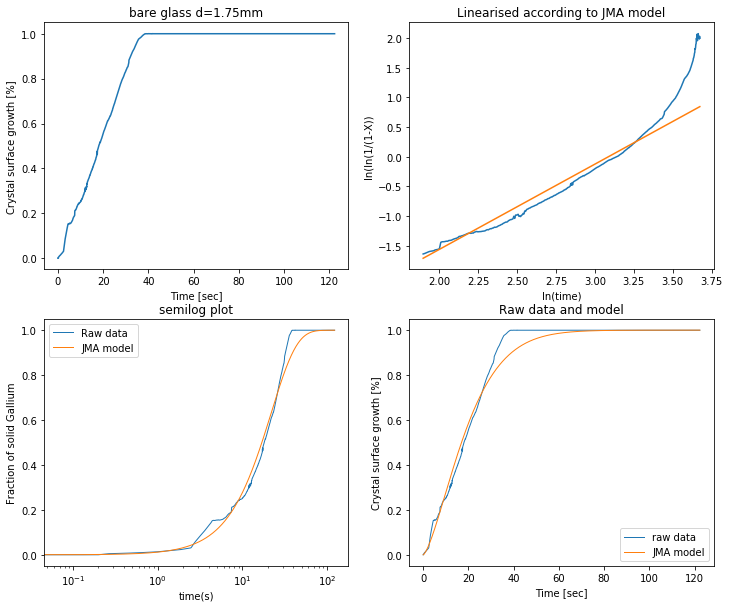

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     1010.
Date:                Mon, 24 Jun 2019   Prob (F-statistic):           6.24e-23
Time:                        23:10:48   Log-Likelihood:                 21.976
No. Observations:                  29   AIC:                            -39.95
Df Residuals:                      27   BIC:                            -37.22
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.4380      0.110    -40.498      0.0

In [5]:
S = genfromtxt('S_crystal_sept_12_03.csv', delimiter=',')
S = np.concatenate((S, np.ones(1200)*S[-1]))

d1_bare = 0
d0_bare = 100
f1_bare = len(S)
f0_bare = len(S)
fr = 15.0
tt_bare, regr_bare, S_bare = crystal_growth(S, fr, 'bare glass d=1.75mm', d1_bare, d0_bare, f0_bare, 34)

### ITO, d= 1.75mm

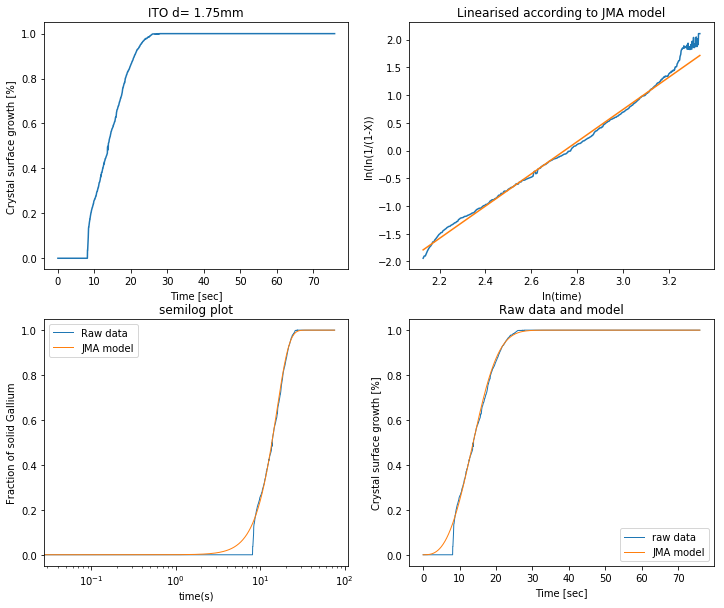

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     5330.
Date:                Mon, 24 Jun 2019   Prob (F-statistic):           1.47e-32
Time:                        23:10:53   Log-Likelihood:                 38.346
No. Observations:                  29   AIC:                            -72.69
Df Residuals:                      27   BIC:                            -69.96
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.9752      0.097    -82.446      0.0

In [6]:
S = genfromtxt('S_crystal_nov_23.csv', delimiter=',')
S = np.concatenate((S, np.ones(1200)*S[-1]))
d1_ITO = 0
d0_ITO = 210
f1_ITO = len(S)
f0_ITO = 800
fr = 25
tt_ITO, regr_ITO, S_ITO = crystal_growth(S, fr, 'ITO d= 1.75mm', d1_ITO, d0_ITO,f0_ITO, 34)

### Bare glass, d = 2.5mm

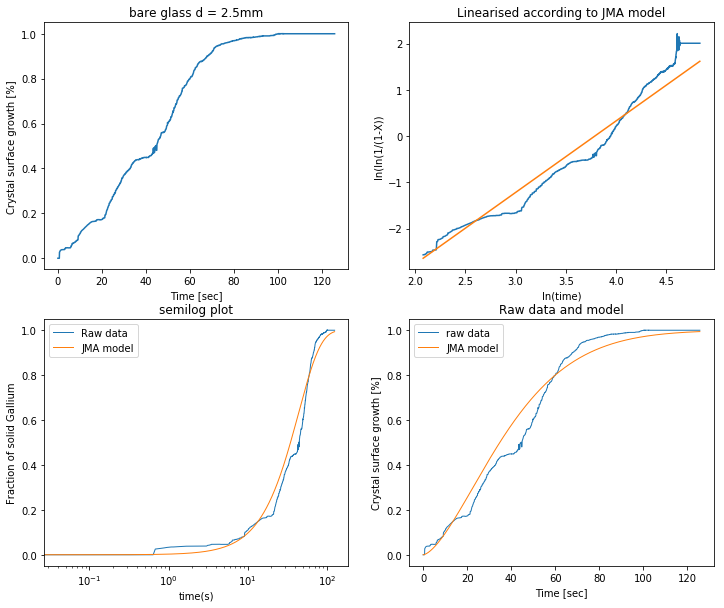

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     1268.
Date:                Mon, 24 Jun 2019   Prob (F-statistic):           3.12e-30
Time:                        23:10:56   Log-Likelihood:                 5.8389
No. Observations:                  39   AIC:                            -7.678
Df Residuals:                      37   BIC:                            -4.351
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.8576      0.126    -46.585      0.0

In [7]:
S = genfromtxt('S_crystal_july_26.csv', delimiter=',')

fr = 25
S = np.concatenate((S, np.ones(550)*S[-1]))

d1_big = 0
d0_big = 200
f1_big = len(S)
f0_big = len(S)
tt_big, regr_big, S_big = crystal_growth(S, fr, 'bare glass d = 2.5mm', 0, 200, len(S), 44)

### Overlay the plots

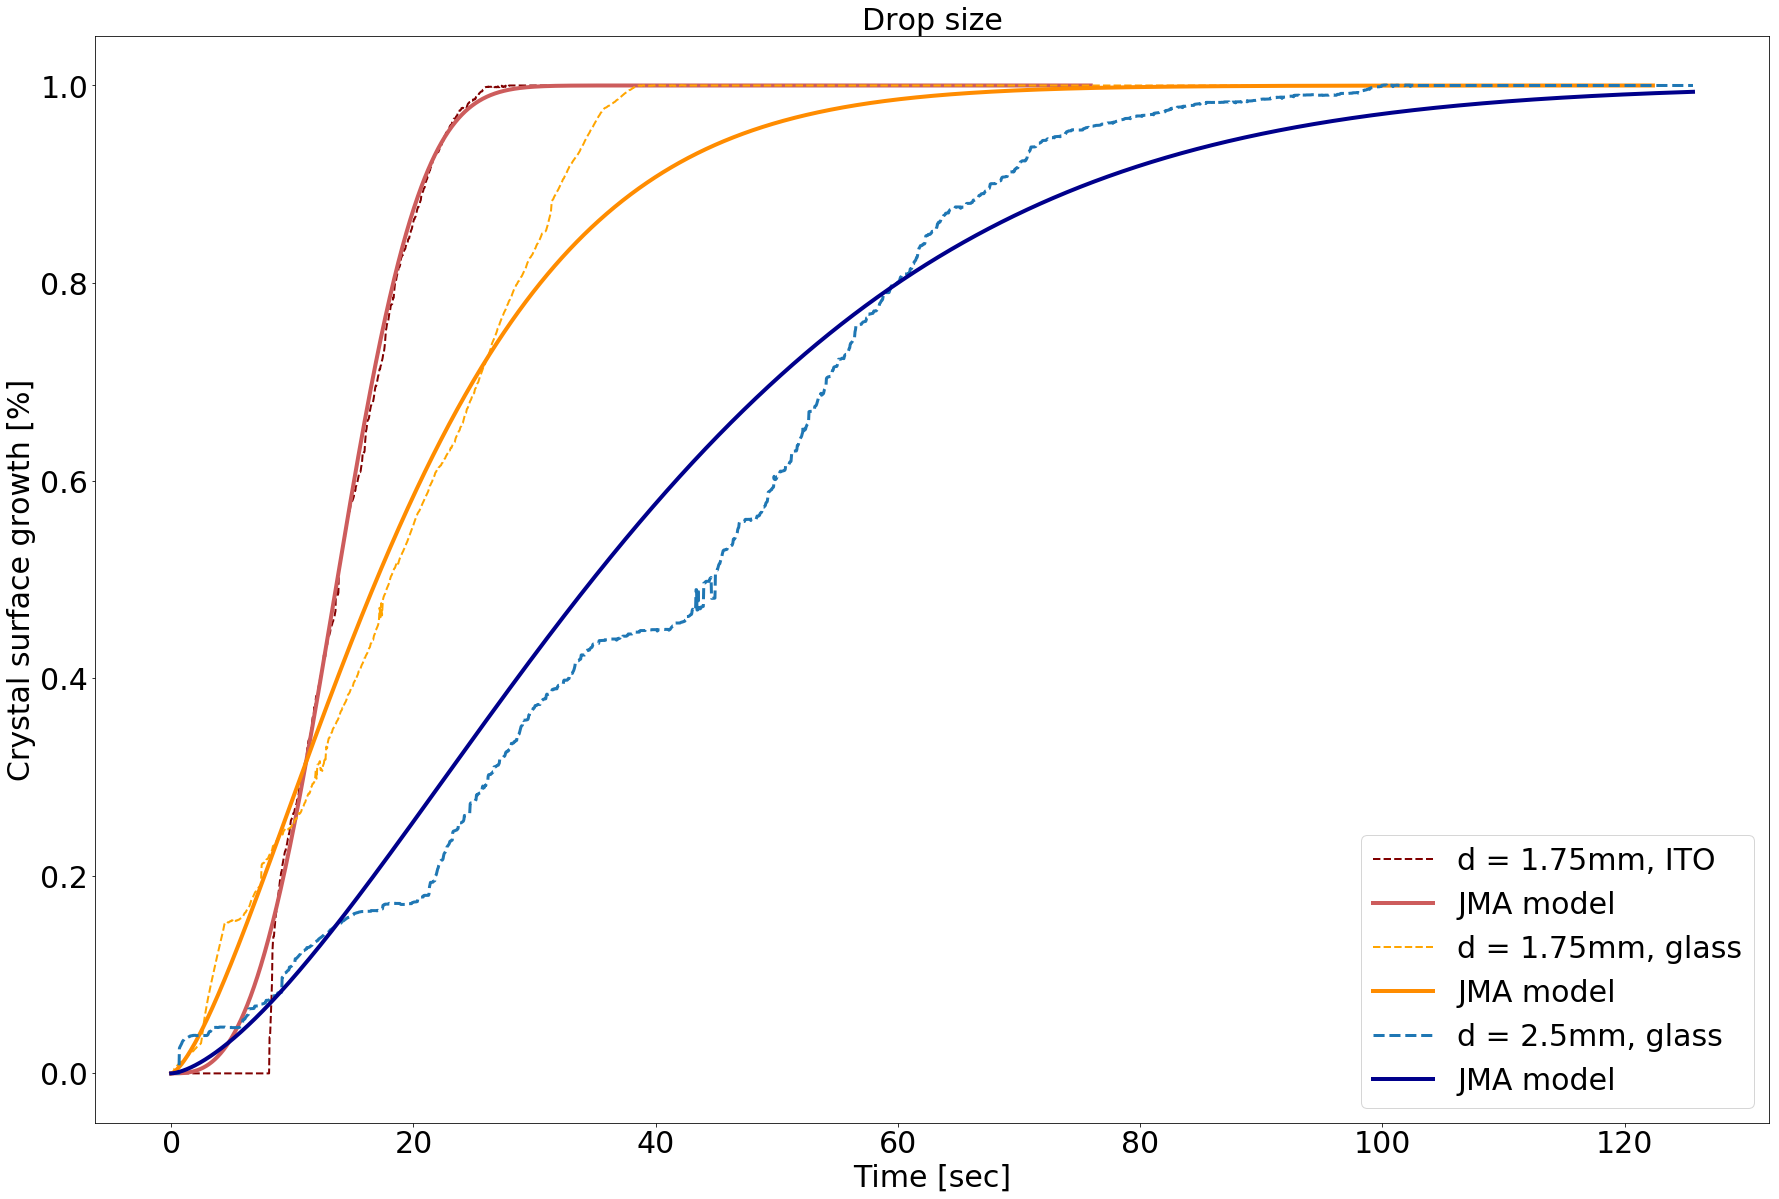

In [8]:
plt.figure(figsize = (30,20))
FS = 30



plt.plot(tt_ITO, S_ITO[d1_ITO:f1_ITO]/S_ITO[-1], '--', label = "d = 1.75mm, ITO", linewidth=2.0, color = 'maroon')
plt.plot(tt_ITO, regr_ITO, label = "JMA model" , color = 'indianred', linewidth = 4)

plt.plot(tt_bare, S_bare/S_bare[-1], '--',  label = "d = 1.75mm, glass", linewidth=2.0, color = 'orange')
plt.plot(tt_bare, regr_bare, label = "JMA model" , color = 'darkorange', linewidth = 4)

plt.plot(tt_big, S_big/S_big[-1], '--', label = "d = 2.5mm, glass", linewidth=3.0)
plt.plot(tt_big, regr_big, label = "JMA model", linewidth = 4, color = 'darkblue')




plt.ylabel('Crystal surface growth [%]', fontsize = FS )
plt.xlabel('Time [sec]', fontsize = FS )
plt.title('Drop size', fontsize = FS )
plt.legend(fontsize = FS)
plt.tick_params(labelsize = FS)

plt.savefig('drop_dependancy_all.png')

plt.show()